In [26]:
# 📦 STEP 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings("ignore")


In [27]:
# 📊 STEP 2: Load Dataset
df = pd.read_csv('Crop_recommendation.csv')  # Adjust path if needed
df.head()


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [28]:
# 🧹 STEP 3: Preprocess
X = df.drop('label', axis=1)
y = df['label']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [29]:
# ⚙️ STEP 4: Define Models
models = {
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True),
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": GaussianNB()
}


Random Forest:
  ➤ Fold Accuracies: [0.99545455 0.99318182 0.99772727 0.99545455 0.99090909]
  ➤ Mean Accuracy: 0.9945
  ➤ Std Deviation: 0.0023

KNN:
  ➤ Fold Accuracies: [0.97045455 0.975      0.97954545 0.95909091 0.97272727]
  ➤ Mean Accuracy: 0.9714
  ➤ Std Deviation: 0.0068

SVM:
  ➤ Fold Accuracies: [0.98181818 0.98409091 0.99090909 0.97727273 0.98409091]
  ➤ Mean Accuracy: 0.9836
  ➤ Std Deviation: 0.0044

Logistic Regression:
  ➤ Fold Accuracies: [0.97045455 0.97045455 0.97045455 0.975      0.97045455]
  ➤ Mean Accuracy: 0.9714
  ➤ Std Deviation: 0.0018

Naive Bayes:
  ➤ Fold Accuracies: [0.99318182 0.99545455 0.99772727 0.99318182 0.99318182]
  ➤ Mean Accuracy: 0.9945
  ➤ Std Deviation: 0.0018



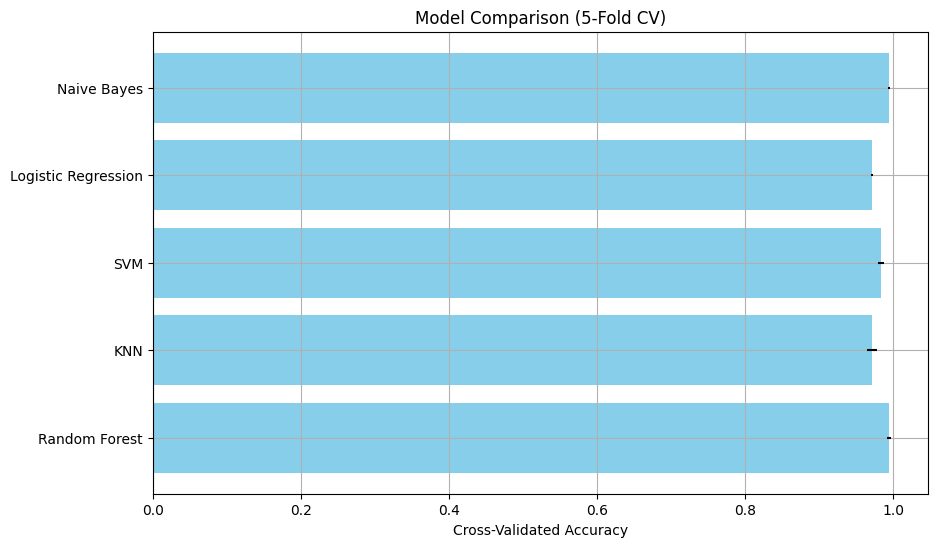

In [18]:
# 📈 STEP 5: Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = {}

for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=cv)
    cv_scores[name] = scores
    print(f"{name}:")
    print(f"  ➤ Fold Accuracies: {scores}")
    print(f"  ➤ Mean Accuracy: {scores.mean():.4f}")
    print(f"  ➤ Std Deviation: {scores.std():.4f}\n")

# Bar Plot
plt.figure(figsize=(10, 6))
means = [np.mean(v) for v in cv_scores.values()]
stds = [np.std(v) for v in cv_scores.values()]
names = list(cv_scores.keys())

plt.barh(names, means, xerr=stds, color='skyblue')
plt.xlabel("Cross-Validated Accuracy")
plt.title("Model Comparison (5-Fold CV)")
plt.grid(True)
plt.show()


In [19]:
# 🧪 STEP 6: Evaluation Function
def evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"🔍 {model_name} Evaluation:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


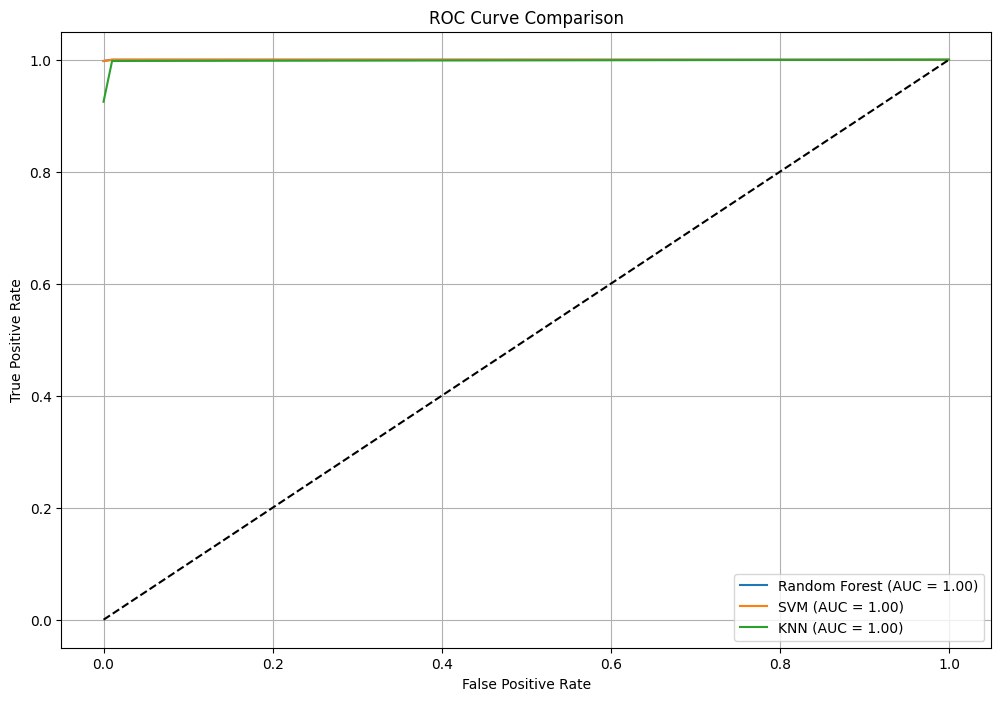

In [20]:
# 📊 STEP 7: ROC Curve Plot (Multiclass)
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]

models_to_plot = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier()
}

plt.figure(figsize=(12, 8))

for name, model in models_to_plot.items():
    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(label_binarize(y_test, classes=np.unique(y))[:, i], y_score[:, i])
        roc_auc[i] = roc_auc_score(label_binarize(y_test, classes=np.unique(y))[:, i], y_score[:, i])

    avg_fpr = np.linspace(0, 1, 100)
    avg_tpr = np.zeros_like(avg_fpr)
    for i in range(n_classes):
        avg_tpr += np.interp(avg_fpr, fpr[i], tpr[i])
    avg_tpr /= n_classes

    plt.plot(avg_fpr, avg_tpr, label=f"{name} (AUC = {np.mean(list(roc_auc.values())):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


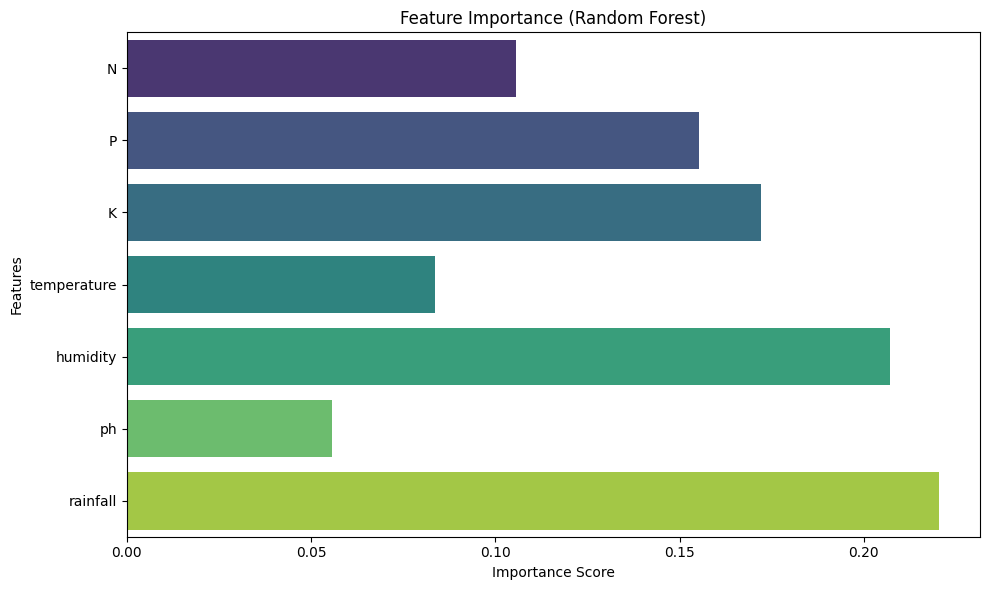

In [21]:
# 🌾 STEP 8: Feature Importance (Random Forest)
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features, palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best SVM Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
🔍 Tuned SVM Evaluation:
Accuracy: 0.9886363636363636
Classification Report:
               precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       0.95      1.00      0.98        20
      grapes       1.00      1.00      1.00        20
        jute       0.87      1.00      0.93        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.95      1.00      0.98        20
       maize       1.00      0.95      0.97        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      0.95   

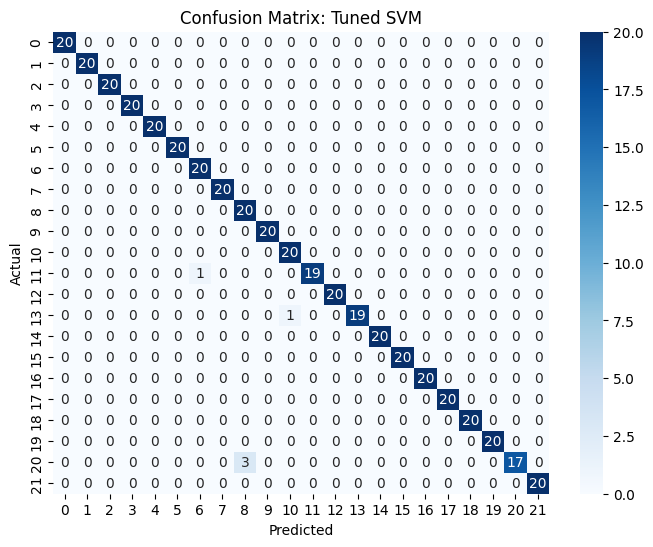

In [22]:
# 🔍 STEP 9: Hyperparameter Tuning - SVM
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=3, verbose=1, n_jobs=-1)
svm_grid.fit(X_train, y_train)

print("Best SVM Parameters:", svm_grid.best_params_)
evaluate_model(svm_grid.best_estimator_, "Tuned SVM")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best KNN Parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
🔍 Tuned KNN Evaluation:
Accuracy: 0.9818181818181818
Classification Report:
               precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        20
     coconut       0.95      1.00      0.98        20
      coffee       1.00      1.00      1.00        20
      cotton       0.95      1.00      0.98        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      1.00      0.98        20
 kidneybeans       0.95      1.00      0.98        20
      lentil       0.95      0.95      0.95        20
       maize       1.00      0.95      0.97        20
       mango       0.95      1.00      0.98        20
   mothbeans       

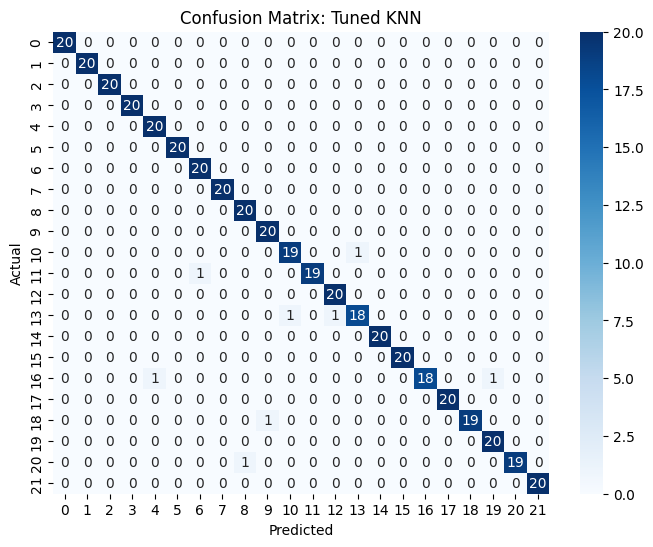

In [23]:
# 🔍 STEP 10: Hyperparameter Tuning - KNN
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=3, verbose=1, n_jobs=-1)
knn_grid.fit(X_train, y_train)

print("Best KNN Parameters:", knn_grid.best_params_)
evaluate_model(knn_grid.best_estimator_, "Tuned KNN")


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best GaussianNB Parameters: {'var_smoothing': 1e-09}
🔍 Tuned GaussianNB Evaluation:
Accuracy: 0.9954545454545455
Classification Report:
               precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.91      1.00      0.95        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        20
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00   

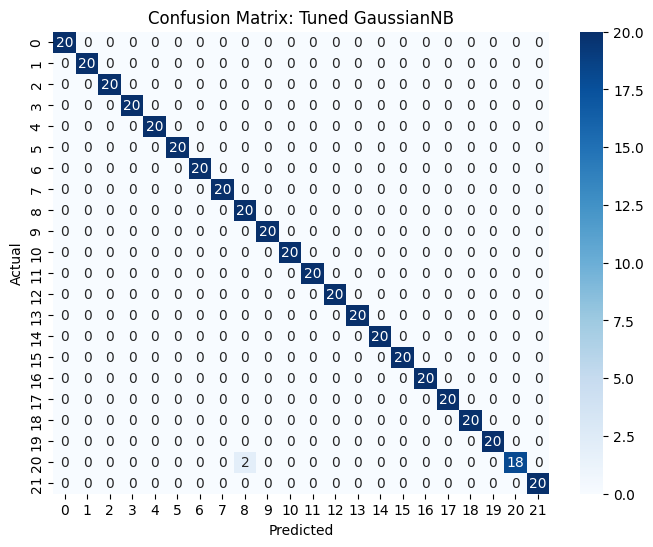

In [24]:
from sklearn.naive_bayes import GaussianNB

# Define hyperparameter grid
gnb_param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

# Grid search
gnb_grid = GridSearchCV(GaussianNB(), gnb_param_grid, cv=3, verbose=1, n_jobs=-1)
gnb_grid.fit(X_train, y_train)

print("Best GaussianNB Parameters:", gnb_grid.best_params_)
evaluate_model(gnb_grid.best_estimator_, "Tuned GaussianNB")


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters from RandomizedSearchCV: {'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 364}
🔍 Tuned Random Forest Evaluation:
Accuracy: 0.9931818181818182
Classification Report:
               precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      0.95      0.97        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      1.00      0.98        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      0.95      0.97        20
       maize       0.95      1.0

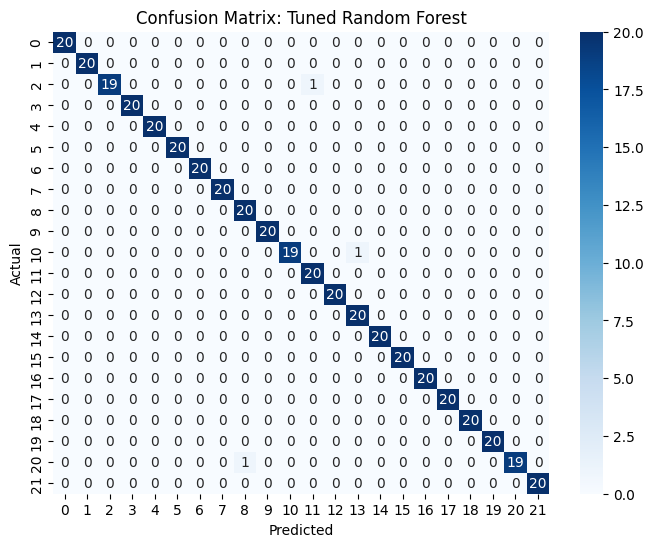

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distributions
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=12,              # Try 20 random combinations
    cv=3,                   # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,              # Use all processors
    random_state=42
)

# Fit to training data
random_search.fit(X_train, y_train)

# Output best parameters
print("Best Parameters from RandomizedSearchCV:", random_search.best_params_)

# Evaluate the best model
evaluate_model(random_search.best_estimator_, "Tuned Random Forest")
